In [46]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from PIL import Image
import os
import warnings
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
warnings.filterwarnings('ignore')
plt.style.use('default')

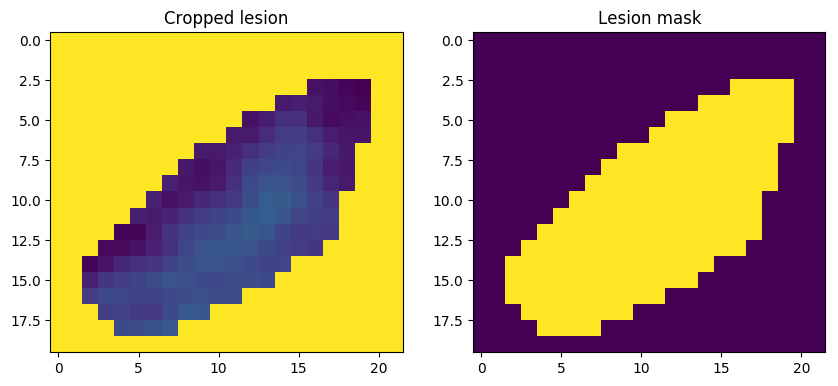

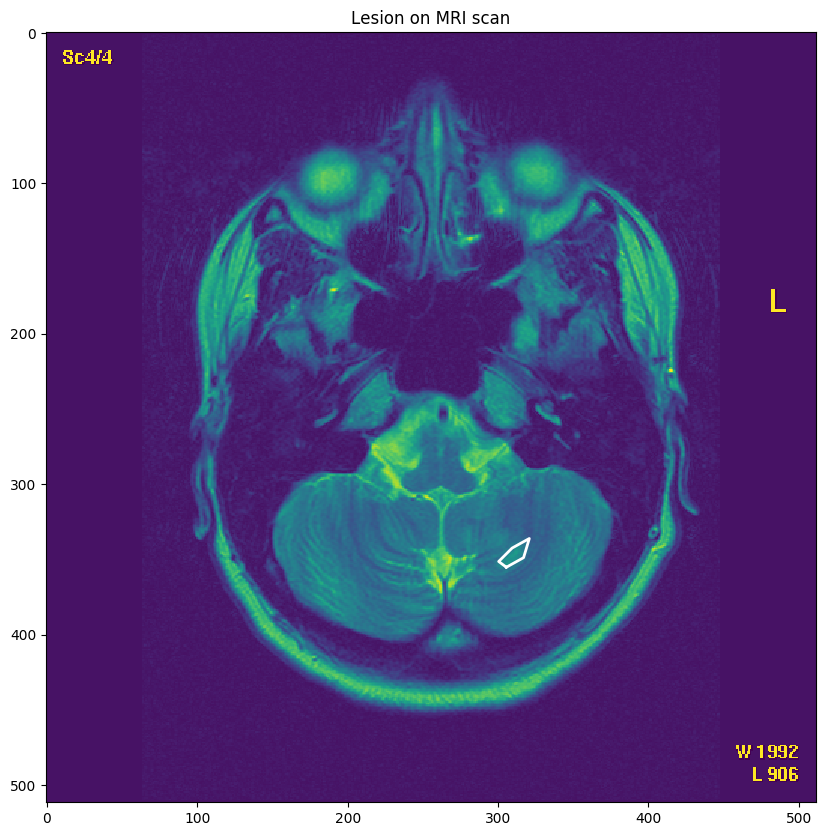

In [47]:
im = Image.open("../data/Initial & repeat MRI in MS-Free Dataset/TZN/2/IM_00004.TIF")
lesion_scan = np.array(im)

lesion_data = loadmat("../data/Initial & repeat MRI in MS-Free Dataset/TZN/2/IM_00004_1.plq")

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(lesion_data["reg"])
plt.title("Cropped lesion")
plt.subplot(122)
plt.imshow(lesion_data["mask"])
plt.title("Lesion mask")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(lesion_scan)
plt.plot(lesion_data["xi"], lesion_data["yi"], color="white", linewidth=2)
plt.title("Lesion on MRI scan")
plt.show()

In [48]:
# Process plq
def process_plq(path):
    leison = loadmat(path)
    return leison["mask"].sum(), (leison["reg"] * leison["mask"]).mean() / 255

shapes = []
for root, _, files in os.walk('../data/Initial & repeat MRI in MS-Free Dataset/'):
    for f in files:
        if ".plq" in f:
            _,_,_, patient, stage = root.split('/')
            path = root + "/" + f
            size, intensity = process_plq(path)
            shapes.append((size, intensity, patient, stage))

In [49]:
shapes_df = pd.DataFrame(shapes, columns = ['size', 'intensity', 'patient', 'stage'])

In [50]:
patient_progress_df = shapes_df.groupby(['stage', 'patient']).agg({'size': ["count", "mean"], 'intensity': ["mean"]}).reset_index()

patient_progress_df.columns = ['stage', 'patient', 'number', 'size_mean', 'intensity_mean']
patient_progress_df.head()

stage patient  number   size_mean  intensity_mean
0     1      AA      38  185.026316        0.308227
1     1     ARK       7   38.142857        0.218597
2     1      AT       9   95.111111        0.289054
3     1    CHEM       7   53.428571        0.197603
4     1     CHP      19   30.368421        0.157853

In [51]:
patient_progress_df = patient_progress_df[patient_progress_df.stage == "1"][["patient", "number", "intensity_mean", "size_mean"]].merge(
    patient_progress_df[patient_progress_df.stage == "2"][["patient", "number", "intensity_mean", "size_mean"]],
    how="left",
    on="patient",
    suffixes=("_initial", "_repeated")
)

In [52]:
patient_progress_df["size_change"] = patient_progress_df["size_mean_repeated"] / patient_progress_df["size_mean_initial"]
patient_progress_df["intensity_change"] = patient_progress_df["intensity_mean_repeated"] / patient_progress_df["intensity_mean_initial"]
patient_progress_df["number_change"] = patient_progress_df["number_repeated"] / patient_progress_df["number_initial"]

In [53]:
patient_progress_df.head()

patient  number_initial  intensity_mean_initial  size_mean_initial  \
0      AA              38                0.308227         185.026316   
1     ARK               7                0.218597          38.142857   
2      AT               9                0.289054          95.111111   
3    CHEM               7                0.197603          53.428571   
4     CHP              19                0.157853          30.368421   

   number_repeated  intensity_mean_repeated  size_mean_repeated  size_change  \
0               36                 0.308126          186.000000     1.005262   
1               10                 0.190021           33.000000     0.865169   
2                8                 0.197010           80.625000     0.847693   
3                9                 0.150787           45.000000     0.842246   
4               22                 0.212683           29.181818     0.960926   

   intensity_change  number_change  
0          0.999671       0.947368  
1          0.869278       1.428571  
2          0.681566       0.888889  
3          0.763078       1.285714  
4          1.347349       1.157895

#### EDSS Matching


In [54]:
edss_score = pd.read_csv('../data/Initial & repeat MRI in MS-Free Dataset/EDSS_matching.csv')
patients_df = pd.read_excel("../data/PatientCodes-Names-full.xls")
patients_df.drop(0, inplace=True)
patients_df.drop(columns=['N'], inplace=True)
edss_score.drop(columns='Unnamed: 0', inplace=True)

patients_df.head()

Date Of bitrh  Date of Exam   Age at onset  CODE  EDSS-5(2010)
1     1970-01-05    2004-05-24           34.0   AT           5.0
2     1973-10-20    2003-11-12           30.0   AA           3.0
3     1953-05-15    2003-01-14           50.0  GPE           3.0
4     1981-03-29    2004-02-11           23.0   HC           1.5
5     1983-07-21    2004-07-21           21.0   IO           8.5

#### Shape Features -- Try them out [Use these features to try on 1 & 2 folders seperately -- Perform wilcoxon test on top of them]
#### 1. Maximum length x and y coords
#### 2. Area -- https://en.wikipedia.org/wiki/Shoelace_formula
#### 3. Perimeter
#### 4. perimeter2/area, 

In [55]:
def define_parameter(coords: list)->float:
    """
    Calculating the parameter for a specific polygon
    Args:
        coords: (x, y) coordinates of a polygon
    
    Returns:
        The parameter of the polygon with calculation of euclidean distance between 2 coords
    """
    if type(coords) != list or len(coords) == 0 or coords is None:
        raise ValueError("Please check the coordinates again!!!")
    
    i=0; per = 0
    while i < len(coords)-1:
        coords0, coords1 = coords[i], coords[i+1]
        per+=distance.euclidean(coords0, coords1)
        i+=1;
    return per

def define_area(x: list, y: list)->float:
    """
    Calculating the Area of a polygon using shoelace formula : https://en.wikipedia.org/wiki/Shoelace_formula
    Args:
        x: list of x values for all the coordinates
        y: list of y values for all the coordinates
        
    Returns:
        Area of a polygon with float format
    """
    if x is None or y is None or len(x) == 0 or len(y) == 0 or type(x) != np.ndarray or type(y) != np.ndarray or type(x) != type(y):
        raise ValueError("Please check the x and y coords!!!")
    elif len(x) != len(y):
        raise ValueError("x and y coordinates are not of same length!!!")
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def process_plq_coordinates(path: str)->list:
    """
    This function is responsible for calculation of multiple shape features together i.e. Max length of x & y coords, 
    area, perimeter, perimeter**2/area
    Args:
        path: string value of a single .plq file
    Returns:
        a list of all the values in together
    """
    if path in ("", " ") or type(path) != str:
        raise ValueError("Please recheck the file path!!!")
    elif not os.path.exists(path):
        raise ValueError("File path doesn't exists!!!")
        
    params = loadmat(path)
    x, y = params["xi"].reshape(-1), params["yi"].reshape(-1)
    ar = define_area(x, y)
    per = define_parameter(list(zip(x, y)))
    return list([params["xi"][np.argmax(params["xi"].reshape(-1))] - params["xi"][np.argmin(params["xi"].reshape(-1))], 
                params["xi"][np.argmax(params["yi"].reshape(-1))] - params["yi"][np.argmin(params["yi"].reshape(-1))], 
                per, ar, (per**2)/ar])
    
def read_points(path:str)->list:
    """
    An intermediate function which calculates the average value of each shape feature for a patient as well as returns
    whole list of values to calculate the mannwhitney test
    
    Args:
        path: string value of a set of .plq files
    Returns:
        a list of individual values for Max length of x & y coords, area, perimeter, perimeter**2/area as well as their
        mean values.
    """
    x_points = []; y_points = []; area = []; per = []; per_by_area = [];
    for root, _, files in os.walk(path):
        for index, file in enumerate(sorted([f for f in files if ".plq" in f])):
            z_index = int(file.split("_")[1].split(".")[0])
            path = root + "/" + file
            vals = process_plq_coordinates(path)
            x_points.append(vals[0][0]); 
            y_points.append(vals[1][0]);
            per.append(vals[2]); 
            area.append(vals[3]); 
            per_by_area.append(vals[4])
    return [x_points, y_points, area, per, per_by_area, np.mean(x_points), np.mean(y_points), np.mean(area), np.mean(per), np.mean(per_by_area)]
   
def calculate_MannWhitney(x: list, y: list)->list:
    """
    Calculates the Mannwhitney statistical test for a list of x and y values
    Args:
        x: list of x values i.e. 0 Months
        y: list of y values i.e. 6-12 Months
    Returns:
        statistics as well as p-value which defines the significance of a feature for a patient
    """
    return mannwhitneyu(x, y)

In [56]:
patients_df.loc[patients_df.CODE == "CHE", "CODE"] = "CHEM"
patients_to_lesions_df = patients_df[["CODE", "EDSS-5(2010)"]].copy().set_index("CODE")

for patient in tqdm_notebook(patients_to_lesions_df.index):
    x_points = []; y_points = []; area = []; per = []; per_by_area = [];
    for period in ["1", "2"]:
        path = "../data/Initial & repeat MRI in MS-Free Dataset/{}/{}".format(patient, period)
        points = read_points(path)
        x_points.append(points[0])
        y_points.append(points[1])
        per.append(points[3]); area.append(points[2]); per_by_area.append(points[4])
        patients_to_lesions_df.loc[patient, "lesions_{}_xcoords".format(period)] = points[5]
        patients_to_lesions_df.loc[patient, "lesions_{}_ycoords".format(period)] = points[6]
        patients_to_lesions_df.loc[patient, "lesions_{}_area".format(period)] = points[7]
        patients_to_lesions_df.loc[patient, "lesions_{}_per".format(period)] = points[8]
        patients_to_lesions_df.loc[patient, "lesions_{}_per_by_area".format(period)] = points[9]
    patients_to_lesions_df.loc[patient, "lesion_xcoords_mannwhitney"] = calculate_MannWhitney(x_points[0], x_points[1])[1]
    patients_to_lesions_df.loc[patient, "lesion_ycoords_mannwhitney"] = calculate_MannWhitney(y_points[0], y_points[1])[1]
    patients_to_lesions_df.loc[patient, "lesion_area_mannwhitney"] = calculate_MannWhitney(area[0], area[1])[1]
    patients_to_lesions_df.loc[patient, "lesion_per_mannwhitney"] = calculate_MannWhitney(per[0], per[1])[1]
    patients_to_lesions_df.loc[patient, "lesion_per_by_area_mannwhitney"] = calculate_MannWhitney(per_by_area[0], x_points[1])[1]

A Jupyter Widget

In [22]:
# At this point we have 2 different cols for each feature type. Implement the wilcoxon test
wilcoxon(patients_to_lesions_df.lesions_1_xcoords, patients_to_lesions_df.lesions_2_xcoords)

WilcoxonResult(statistic=277.0, pvalue=0.1751110121160112)

In [23]:
wilcoxon(patients_to_lesions_df.lesions_1_ycoords, patients_to_lesions_df.lesions_2_ycoords)

WilcoxonResult(statistic=358.0, pvalue=0.8561490233719683)

In [24]:
wilcoxon(patients_to_lesions_df.lesions_1_area, patients_to_lesions_df.lesions_2_area)

WilcoxonResult(statistic=273.0, pvalue=0.15737015953167466)

In [25]:
wilcoxon(patients_to_lesions_df.lesions_1_per, patients_to_lesions_df.lesions_2_per)

WilcoxonResult(statistic=290.0, pvalue=0.24303547341118348)

In [26]:
wilcoxon(patients_to_lesions_df.lesions_1_per_by_area, patients_to_lesions_df.lesions_2_per_by_area)

WilcoxonResult(statistic=357.0, pvalue=0.8447817999706625)

In [57]:
patients_to_lesions_df.head()

EDSS-5(2010)  lesions_1_xcoords  lesions_1_ycoords  lesions_1_area  \
CODE                                                                       
AT             5.0          13.331538          -7.728844       98.386840   
AA             3.0          15.800957         -13.000744      185.741466   
GPE            3.0          12.955023         -15.011947      131.225355   
HC             1.5          28.341010         -22.585628      668.616790   
IO             8.5          19.779699         -36.748866      269.457238   

      lesions_1_per  lesions_1_per_by_area  lesions_2_xcoords  \
CODE                                                            
AT        41.102055              18.925791          14.092929   
AA        53.140829              16.421193          15.572615   
GPE       45.194149              17.902966          17.452354   
HC        96.999808              18.350229          18.115786   
IO        64.087474              19.445774          15.515152   

      lesions_2_ycoords  lesions_2_area  lesions_2_per  lesions_2_per_by_area  \
CODE                                                                            
AT           -18.553535       91.339839      44.071824              25.465494   
AA             0.014366      188.433924      54.655535              17.411255   
GPE           24.995172      202.322605      56.323052              18.419062   
HC           -33.047273      243.776688      61.914857              17.538156   
IO           -40.423932      162.578535      54.036748              19.376829   

      lesion_xcoords_mannwhitney  lesion_ycoords_mannwhitney  \
CODE                                                           
AT                      0.480813                    0.206703   
AA                      0.420682                    0.174764   
GPE                     0.000644                    0.006310   
HC                      0.009543                    0.357877   
IO                      0.006197                    0.396618   

      lesion_area_mannwhitney  lesion_per_mannwhitney  \
CODE                                                    
AT                   0.442617                0.404947   
AA                   0.497843                0.296206   
GPE                  0.001047                0.001923   
HC                   0.004254                0.007518   
IO                   0.029996                0.031598   

      lesion_per_by_area_mannwhitney  
CODE                                  
AT                          0.081468  
AA                          0.138505  
GPE                         0.031652  
HC                          0.416272  
IO                          0.000003

In [58]:
patients_to_lesions_df['EDSS5'] = patients_to_lesions_df['EDSS-5(2010)']
patients_to_lesions_df.drop(columns=['EDSS-5(2010)'], inplace=True)

In [59]:
def calculate_change(row, col):
    return row['lesions_2_{}'.format(col)] / row['lesions_1_{}'.format(col)]
"""
def fix_edss5(x):
    x = x.replace(')','').replace('(', '')
    return x
"""

#patients_to_lesions_df['EDSS5'] = patients_to_lesions_df['EDSS5'].apply(lambda x: fix_edss5(x)).astype('float32')
patients_to_lesions_df['xcoords_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'xcoords'), axis=1)
patients_to_lesions_df['ycoords_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'ycoords'), axis=1)
patients_to_lesions_df['area_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'area'), axis=1)
patients_to_lesions_df['per_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'per'), axis=1)
patients_to_lesions_df['per_by_area_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'per_by_area'), axis=1)

In [60]:
patients_to_lesions_df.corr()['EDSS5']

lesions_1_xcoords                 0.144280
lesions_1_ycoords                -0.198268
lesions_1_area                    0.051603
lesions_1_per                     0.144150
lesions_1_per_by_area             0.152446
lesions_2_xcoords                 0.162363
lesions_2_ycoords                -0.098447
lesions_2_area                    0.145138
lesions_2_per                     0.219198
lesions_2_per_by_area             0.264133
lesion_xcoords_mannwhitney        0.046144
lesion_ycoords_mannwhitney        0.023962
lesion_area_mannwhitney           0.012532
lesion_per_mannwhitney           -0.051232
lesion_per_by_area_mannwhitney   -0.015079
EDSS5                             1.000000
xcoords_change                    0.000494
ycoords_change                    0.121616
area_change                       0.011392
per_change                        0.063324
per_by_area_change                0.142852
Name: EDSS5, dtype: float64

In [44]:
patients_to_lesions_df[[x for x in patients_to_lesions_df.columns if 'mannwhitney' in x]]

lesion_xcoords_mannwhitney  lesion_ycoords_mannwhitney  \
CODE                                                           
AT                      0.480813                    0.206703   
AA                      0.420682                    0.174764   
GPE                     0.000644                    0.006310   
HC                      0.009543                    0.357877   
IO                      0.006197                    0.396618   
MJ                      0.495543                    0.163715   
IPH                     0.404027                    0.307815   
KM                      0.500000                    0.446965   
NP                      0.204275                    0.281544   
TA                      0.105832                    0.274209   
SE                      0.254354                    0.179653   
MME                     0.179309                    0.340401   
MK                      0.115600                    0.485557   
SST                     0.129549                    0.403393   
PM                      0.068253                    0.443392   
NGE                     0.238365                    0.305216   
CP                      0.329836                    0.102245   
IY                      0.054448                    0.072576   
KKY                     0.400153                    0.173454   
PRI                     0.118114                    0.498966   
SKS                     0.251286                    0.431329   
TZN                     0.274657                    0.001387   
ARK                     0.128512                    0.130871   
CHP                     0.072348                    0.024197   
CHEM                    0.156951                    0.133014   
DK                      0.011239                    0.004057   
FA                      0.199578                    0.341333   
FI                      0.486127                    0.037640   
IG                      0.056691                    0.075306   
KAZM                    0.166405                    0.172852   
TE                      0.429842                    0.297942   
SP                      0.442325                    0.234397   
KCH                     0.475482                    0.198776   
PGE                     0.230479                    0.435384   
GSOU                    0.402538                    0.036043   
TSA                     0.135886                    0.113757   
CK                      0.101465                    0.441446   
TZDE                    0.474384                    0.497441   

      lesion_area_mannwhitney  lesion_per_mannwhitney  \
CODE                                                    
AT                   0.442617                0.404947   
AA                   0.497843                0.296206   
GPE                  0.001047                0.001923   
HC                   0.004254                0.007518   
IO                   0.029996                0.031598   
MJ                   0.442269                0.387165   
IPH                  0.326310                0.354870   
KM                   0.446965                0.500000   
NP                   0.324861                0.267862   
TA                   0.163984                0.205492   
SE                   0.256945                0.180383   
MME                  0.033314                0.026892   
MK                   0.164117                0.164117   
SST                  0.176936                0.130871   
PM                   0.017685                0.045260   
NGE                  0.388072                0.352301   
CP                   0.348113                0.413100   
IY                   0.043989                0.072576   
KKY                  0.400382                0.400382   
PRI                  0.024719                0.009897   
SKS                  0.318158                0.326451   
TZN                  0.081355                0.073112   
ARK                  0.232107                0.203407   
CHP                 

From initial investigation, it seems that changes in raw area from onset to 6-12 months, per, per^2/area aren't significant. Though there is high correlation between EDSS5 and per, area and per_by_area which increases over the time thus these variables can't be ruled out completely.